In [1]:
%pylab inline
import numpy as np
import torch
import os
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch import autograd
from torch.autograd import Variable
import nibabel as nib
from torch.utils.data.dataset import Dataset
from torch.utils.data import dataloader
from nilearn import plotting
# from ADNI_dataset import *
from BRATS_dataset_copy import *
# from ATLAS_dataset import *
from Model_alphaWGAN_copy import Discriminator, Generator, Code_Discriminator, Discriminator_content
# from losses import losses_computer
from copy import deepcopy
from models import Discriminator_test

Populating the interactive namespace from numpy and matplotlib


# Configuration

In [2]:
BATCH_SIZE=3
gpu = True
workers = 0

LAMBDA= 10
_eps = 1e-15
Use_BRATS=True
Use_ATLAS = False

#setting latent variable sizes
latent_dim = 1000

In [3]:
# trainset = ADNIdataset(augmentation=True)
# train_loader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,
#                                           shuffle=True,num_workers=workers)
if Use_BRATS:
    #'flair' or 't2' or 't1ce'
    trainset = BRATSdataset(imgtype='flair')
    train_loader = torch.utils.data.DataLoader(trainset,batch_size = BATCH_SIZE, shuffle=True,
                                               num_workers=workers)
# if Use_ATLAS:
#     trainset = ATLASdataset(augmentation=True)
#     train_loader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,
#                                           shuffle=True,num_workers=workers)

In [4]:
def inf_train_gen(data_loader):
    while True:
        for _,images in enumerate(data_loader):
            yield images

gen_load = inf_train_gen(train_loader)
batch= gen_load.__next__()  # real_images[0]:images  real_images[1]:maskes
real_images=batch[0]  
real_masks=batch[1]
print(real_images)

In [6]:
# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter('save') 

G = Generator(noise = latent_dim)
CD = Code_Discriminator(code_size = latent_dim ,num_units = 4096)
D = Discriminator(is_dis=True)
DL = Discriminator_test()
E = Discriminator(out_class = latent_dim,is_dis=False)
# G_L = GeneratorUNet()

G.cuda()
D.cuda()
CD.cuda()
E.cuda()
DL.cuda()

# dummy_input = Variable(torch.randn((4,latent_dim)),volatile=True).cuda()
# mask = torch.zeros(4, 1, 64, 64, 64).cuda()
# dummy_input = torch.rand(4, 1, 64, 64, 64).cuda()  # 网络中输入的数据维度
# input_i = torch.rand(4, 1, 64, 64, 64).cuda()
# dummy_input = torch.cat((input_i, mask), 1)

# with SummaryWriter(comment='D_11') as w:
#     w.add_graph(D, (dummy_input)) 

Created Discriminator (2+4 blocks) with 1322680 parameters


Discriminator_test(
  (body_ll): ModuleList(
    (0): D_block(
      (activ): LeakyReLU(negative_slope=0.2)
      (conv1): Conv3d(1, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (conv2): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (norm1): BatchNorm3d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (norm2): BatchNorm3d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (down): AvgPool3d(kernel_size=2, stride=2, padding=0)
      (conv_sc): Conv3d(1, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
    )
    (1): D_block(
      (activ): LeakyReLU(negative_slope=0.2)
      (conv1): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (conv2): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (norm1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (norm2): BatchNorm3d(32, eps=1e-0

In [7]:
g_optimizer = optim.Adam(G.parameters(), lr=0.0002)
d_optimizer = optim.Adam(D.parameters(), lr=0.0002)
e_optimizer = optim.Adam(E.parameters(), lr = 0.0002)
cd_optimizer = optim.Adam(CD.parameters(), lr = 0.0002)
# g_l_optimizer = optim.Adam(G_L.parameters(), lr = 0.0002)
d_l_optimizer = optim.Adam(DL.parameters(), lr = 0.0002)

In [8]:
def calc_gradient_penalty_change(model, x, x_gen, y_gen, epoch, w=10):
    """WGAN-GP gradient penalty"""
    assert x.size()==x_gen.size(), "real and sampled sizes do not match"
    alpha_size = tuple((len(x), *(1,)*(x.dim()-1)))
    alpha_t = torch.cuda.FloatTensor if x.is_cuda else torch.Tensor
    alpha = alpha_t(*alpha_size).uniform_()
    x_hat = x.data*alpha + x_gen.data*(1-alpha)
    x_hat = Variable(x_hat, requires_grad=True)

    def eps_norm(x):
        x = x.view(len(x), -1)
        return (x*x+_eps).sum(-1).sqrt()
    def bi_penalty(x):
        return (x-1)**2
    
    X = model(x_hat,y_gen,for_real=False,epoch=epoch)["layout"]
    x = 0
    for i in range(len(X)):
        x = x + X[i].sum()
    
    grad_xhat = torch.autograd.grad(x, x_hat, create_graph=True, only_inputs=True)[0]

    penalty = w*bi_penalty(eps_norm(grad_xhat)).mean()
    return penalty

def calc_gradient_penalty(model, x, x_gen, w=10):
    """WGAN-GP gradient penalty"""
    assert x.size()==x_gen.size(), "real and sampled sizes do not match"
    alpha_size = tuple((len(x), *(1,)*(x.dim()-1)))
    alpha_t = torch.cuda.FloatTensor if x.is_cuda else torch.Tensor
    alpha = alpha_t(*alpha_size).uniform_()
    x_hat = x.data*alpha + x_gen.data*(1-alpha)
    x_hat = Variable(x_hat, requires_grad=True)

    def eps_norm(x):
        x = x.view(len(x), -1)
        return (x*x+_eps).sum(-1).sqrt()
    def bi_penalty(x):
        return (x-1)**2

    
    grad_xhat = torch.autograd.grad(model(x_hat).sum(), x_hat, create_graph=True, only_inputs=True)[0]

    penalty = w*bi_penalty(eps_norm(grad_xhat)).mean()
    return penalty

In [9]:
def wgan_loss(output, real, forD):
    if real and forD:
        ans = output.mean()
    elif not real and forD:
        ans = -output.mean()
    elif real and not forD:
        ans = -output.mean()
    elif not real and not forD:
        raise ValueError("gen loss should be for real")
    #print(real, forD, ans)
    return ans

In [10]:
class losses_computer():
    def __init__(self, num_blocks):
        """
        The class implementing the loss computations
        """
        self.loss_function = wgan_loss  # 选择损失函数                              
        self.no_masks = False
        # self.no_DR = opt.no_DR
        self.lambdas = {"content": 0.5 / num_blocks,
                        "layout": 0.5 / num_blocks,
                        "low-level": 1.0 / num_blocks}

    # def get_loss_function(self, loss_mode):
        # if loss_mode == "wgan":
        #     return wgan_loss
        # elif loss_mode == "hinge":
        #     return hinge_loss
        # elif loss_mode == "bce":
        #     return bce_loss
        # else:
        #     raise ValueError('Unexpected loss_mode {}'.format(mode))

    def content_segm_loss(self, out_d, data, real, forD):  # out_d --> Dcon 的输出 [15, 4, 1, 1] data --> G的输出
        """
        The multi-class cross-entropy loss used in the content masked attention
        """
        mask = data
        mask_ch = mask.shape[1]
        if real:
            ground_t = torch.arange(mask_ch).unsqueeze(1).unsqueeze(2).unsqueeze(3).unsqueeze(4)  #[ch, 1, 1, 1, 1]
            ground_t = ground_t.repeat(1, 1, out_d.shape[2], out_d.shape[3], out_d.shape[4])
            ground_t = ground_t.repeat_interleave(mask.shape[0], dim=0)[:, 0, :, :, :]  # 沿着指定的维度重复张量的元素  [ch*mask.shape[0], 1, 1]
        else:  # fake
            ground_t = torch.ones_like(out_d)[:, 0, :, :, :] * mask_ch
        weights = torch.cat((1 / (torch.sum(mask.detach(), dim=(0, 2, 3, 4))), torch.Tensor([1.0]).to(out_d.device)))
        weights[weights == float('inf')] = 0
        loss = F.cross_entropy(out_d, ground_t.long().to(out_d.device), weight=weights.to(out_d.device))
        return loss

    # def diversity_regularization(self, fake):
    #     """
    #     The diversity regularization applied in the feature space of the generator
    #     """
    #     loss = torch.nn.L1Loss()
    #     ans = 0
    #     for i in range(len(fake)):
    #         for k in range(fake[i].shape[0]):
    #             for m in range(k + 1, fake[i].shape[0]):
    #                 ans += -loss(fake[i][k], fake[i][m])
    #     return ans * 2 / (len(fake) * (len(fake) - 1))

    def balance_losses(self, losses):
        """
        Multiply each loss part with its lambda
        """
        for item in losses:
            if item in self.lambdas.keys():
                losses[item] = losses[item] * self.lambdas[item]
        return losses

    def __call__(self, out_d, mask, real, forD):
        losses = {}
        # --- adversarial loss ---#
        for item in out_d:
            for i in range(len(out_d[item])):
                if item == "content" and not self.no_masks:
                    losses[item] = losses.get(item, 0) + self.content_segm_loss(out_d[item][i], mask, real, forD)  # .get() 返回键值并赋值0
                else:
                    losses[item] = losses.get(item, 0) + self.loss_function(out_d[item][i], real, forD)

        # --- diversity regularization ---#
        # if not forD and not self.no_DR:
        #     losses["DR"] = self.diversity_regularization(data["features"])
        losses = self.balance_losses(losses)
        return losses

In [11]:

def content_segm_loss(out_d, data, real):
    """
    The multi-class cross-entropy loss used in the content masked attention
    """
    mask = data
    mask_ch = mask.shape[1]
    if real:
        ground_t = torch.arange(mask_ch).unsqueeze(1).unsqueeze(2).unsqueeze(3).unsqueeze(4)  # [1, 1, 1, 1, 1]
        ground_t = ground_t.repeat(1, 1, out_d.shape[2], out_d.shape[3], out_d.shape[4])
        ground_t = ground_t.repeat_interleave(mask.shape[0], dim=0)[:, 0, :, :, :]  # 沿着指定的维度重复张量的元素
    else:  # fake
        ground_t = torch.ones_like(out_d)[:, 0, :, :, :] * mask_ch
    # weights = torch.cat((1 / (torch.sum(mask.detach(), dim=(0, 2, 3, 4))), torch.Tensor([1.0]).to(out_d.device)))
    weights = 1 / (torch.sum(mask.detach(), dim=(1, 2, 3, 4)))
    weights[weights == float('inf')] = 0
    # weights = weights.max()
    loss = F.cross_entropy(out_d, ground_t.long().to(out_d.device), weight=weights.to(out_d.device))
    return loss


In [12]:
def de_one_hot(mask):
    mask = torch.moveaxis(mask,1,4)
    de_mask = torch.zeros((mask.shape[0],mask.shape[1],mask.shape[2],mask.shape[3])).cuda()
    for b in range(mask.shape[0]):
        for x in range(mask.shape[1]):
            for y in range(mask.shape[2]):
                for z in range(mask.shape[3]):
                    de_mask[b][x][y][z] = torch.argmax(mask[b][x][y][z])
    return de_mask

# Training

In [13]:
# real_y = Variable(torch.ones((BATCH_SIZE, 1)).cuda(non_blocking=True))
# fake_y = Variable(torch.zeros((BATCH_SIZE, 1)).cuda(non_blocking=True))


losses_com = losses_computer(DL.num_blocks)
criterion_bce = nn.BCELoss()
criterion_l1 = nn.L1Loss()
criterion_mse = nn.MSELoss()

In [14]:
def load_pth(model, dir, model_weight_list):
    model_weight_path = os.path.join(dir,model_weight_list)
    model_data = torch.load(model_weight_path)
    return model.load_state_dict(model_data)

In [15]:
checkpoint = False

if checkpoint == True:
    checkpoint_dir = "checkpoint1\weiget"
    model_weight_list = os.listdir(checkpoint_dir)

    for i in range(len(model_weight_list)):
        if model_weight_list[i][1] == "_":
            if model_weight_list[i][0] == "E":
                load_pth(E, checkpoint_dir, model_weight_list[i])
            # elif model_weight_list[i][0] == "D":
            #     load_pth(D, checkpoint_dir, model_weight_list[i])
            else:
                load_pth(G, checkpoint_dir, model_weight_list[i])
        else:
            if model_weight_list[i][0] == "C":
                load_pth(CD, checkpoint_dir, model_weight_list[i])
            else:
                load_pth(DL, checkpoint_dir, model_weight_list[i])

C:\Users\MuYang\AppData\Local\Temp\ipykernel_29356\3409005276.py:41: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  real_images = Variable(real_images,volatile=True).cuda(non_blocking=True)
C:\Users\MuYang\AppData\Local\Temp\ipykernel_29356\3409005276.py:42: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  real_masks = Variable(real_masks,volatile=True).cuda(non_blocking=True)
C:\Users\MuYang\AppData\Local\Temp\ipykernel_29356\3409005276.py:43: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  z_rand = Variable(torch.randn((_batch_size,latent_dim)),volatile=True).cuda()  # 随机向量 Zr
e:\Program Files\Python39\lib\site-packages\torch\nn\functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
e:\Program 

[0/200000] D: 4.05e+02 En_Ge: 9.19     Code: 1.96    
[100/200000] D: 0.982    En_Ge: -13.8    Code: 8.9     
[200/200000] D: 0.21     En_Ge: -31.8    Code: 7.9     


KeyboardInterrupt: 

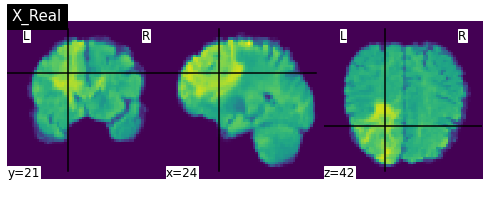

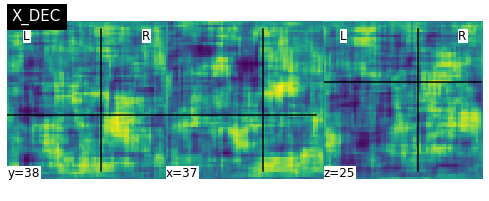

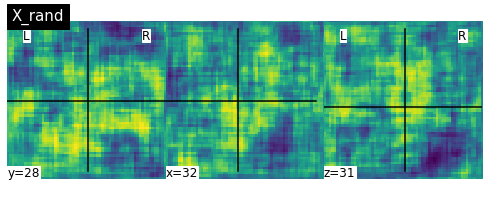

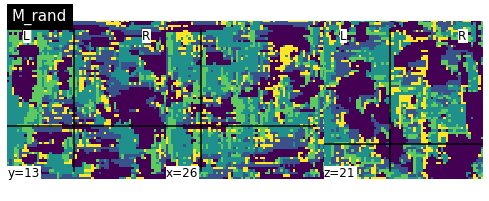

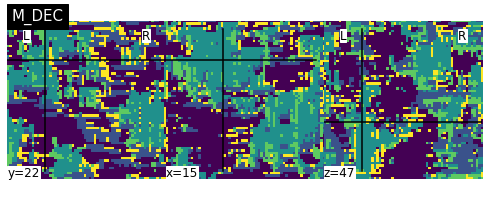

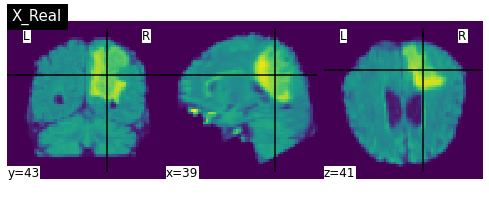

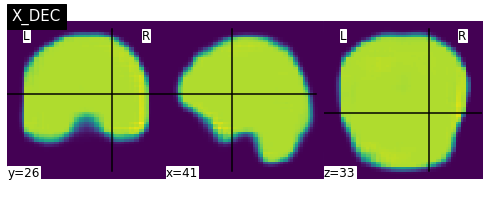

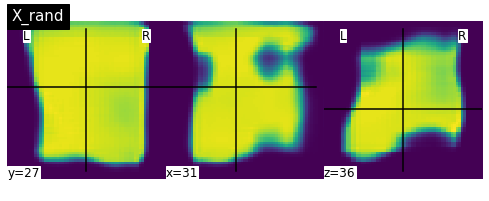

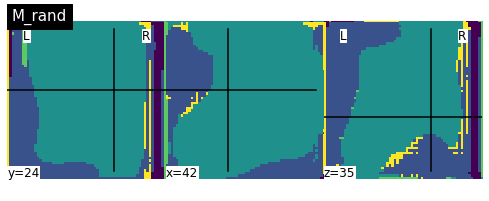

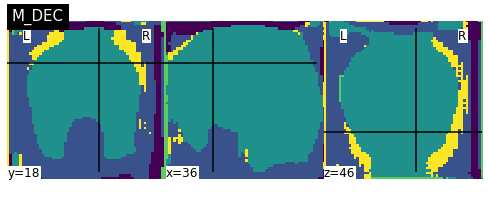

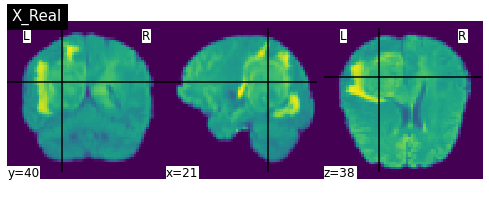

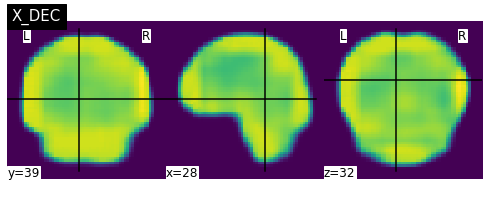

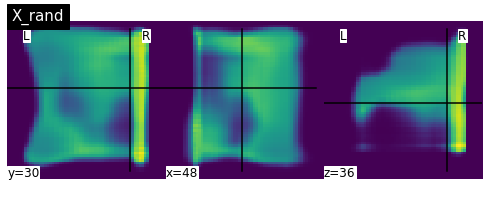

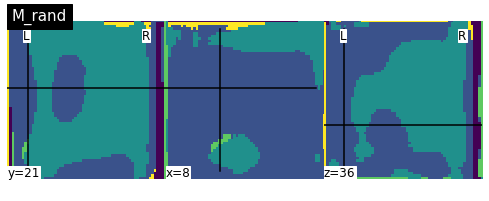

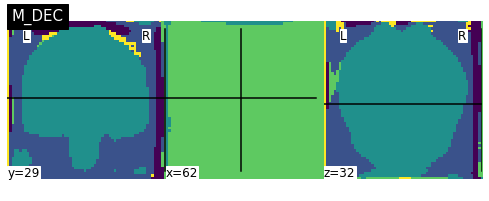

In [16]:
torch.autograd.set_detect_anomaly = True
g_iter = 1
d_iter = 1
cd_iter =1

# mask = torch.zeros(4, 1, 64, 64, 64).cuda()
TOTAL_ITER = 200000
gen_load = inf_train_gen(train_loader)
epoch = 2000
for iteration in range(TOTAL_ITER):
    if checkpoint == True:
        iteration = iteration + epoch + 1
    ###############################################
    # Train Encoder - Generator 
    ###############################################
    # for p in D.parameters():
    #     p.requires_grad = False
    for p in CD.parameters():
        p.requires_grad = False
    for p in E.parameters():
        p.requires_grad = True
    for p in G.parameters():
        p.requires_grad = True

    for p in DL.parameters():
        p.requires_grad = False

    ############方案一F#############
    # for p in G_L.parameters():
    #     p.requires_grad = True
    ###############################

    for iters in range(g_iter):
        logits, losses = dict(), dict()
        G.zero_grad()
        E.zero_grad()
        batch= gen_load.__next__()
        real_images=batch[0]
        real_masks=batch[1]
        _batch_size = real_images.size(0)
        real_images = Variable(real_images,volatile=True).cuda(non_blocking=True)
        real_masks = Variable(real_masks,volatile=True).cuda(non_blocking=True)
        z_rand = Variable(torch.randn((_batch_size,latent_dim)),volatile=True).cuda()  # 随机向量 Zr
        z_hat = E(real_images).view(_batch_size,-1)  # 编码向量 Ze
        x_hat, m_hat = G(z_hat)  # Xrec
        x_rand, m_rand = G(z_rand)  # Xrand

        #########################方案一F#################################
        # y_hat = G_L(x_hat)  # Xrec-label
        # y_rand = G_L(x_rand)  # Xrand-label

        # xy_hat = torch.cat((x_hat, y_hat), 1)  # 拼接图像与标签
        # xy_rand = torch.cat((x_rand, y_rand), 1)

        # xm_hat = torch.cat((x_hat, mask), 1)  # 拼接图像与掩膜
        # xm_rand = torch.cat((x_rand, mask), 1)
        ################################################################

        logits["G_h"] = DL(x_hat, m_hat, for_real=False, epoch=iteration)
        logits["G_r"] = DL(x_rand, m_rand, for_real=False, epoch=iteration)

        losses["G_h"] = losses_com(logits["G_h"], m_hat, real=True, forD=False)
        losses["G_r"] = losses_com(logits["G_r"], m_rand, real=True, forD=False)

        c_loss = -CD(z_hat).mean()


        # d_real_loss = D(x_hat).mean()
        # d_fake_loss = D(x_rand).mean()
        d_real_loss = losses["G_h"]["low-level"] + losses["G_h"]["layout"]
        d_fake_loss = losses["G_r"]["low-level"] + losses["G_r"]["layout"]

        d_loss = d_fake_loss+d_real_loss  # -Eze[D(G(Ze))]-Ezr[D(G(Zr))]
        l1_loss =10* criterion_l1(x_hat,real_images)  # 
        loss1 = l1_loss + c_loss + d_loss + losses["G_h"]["content"] \
                + losses["G_r"]["content"]


        loss1.backward(retain_graph=True)
        


    ###############################################
    # Train D
    ###############################################
    # for p in D.parameters():  
    #     p.requires_grad = True
    for p in CD.parameters():  
        p.requires_grad = False
    for p in E.parameters():  
        p.requires_grad = False
    for p in G.parameters():  
        p.requires_grad = False

    for p in DL.parameters():
        p.requires_grad = True

    # for p in G_L.parameters():
    #     p.requires_grad = False

    for iters in range(d_iter):
        # d_optimizer.zero_grad()
        d_l_optimizer.zero_grad()
        batch= gen_load.__next__()
        real_images=batch[0]
        real_masks=batch[1]
        _batch_size = real_images.size(0)
        z_rand = Variable(torch.randn((_batch_size,latent_dim)),volatile=True).cuda()
        real_images = Variable(real_images,volatile=True).cuda(non_blocking=True)
        real_masks = Variable(real_masks,volatile=True).cuda(non_blocking=True)

        z_hat = E(real_images).view(_batch_size,-1)
        x_hat, m_hat = G(z_hat)
        x_rand, m_rand = G(z_rand)

        logits["D_h"] = DL(x_hat, m_hat, for_real=False, epoch=iteration)
        logits["D_r"] = DL(x_rand, m_rand, for_real=False, epoch=iteration)
        logits["D_i"] = DL(real_images, real_masks, for_real=True, epoch=iteration)

        losses["D_h"] = losses_com(logits["D_h"], m_hat, real=True, forD=True)
        losses["D_r"] = losses_com(logits["D_r"], m_rand, real=True, forD=True)
        losses["D_i"] = losses_com(logits["D_i"], m_rand, real=False, forD=True)

        losses_D_h = losses["D_h"]["low-level"] + losses["D_h"]["layout"] + losses["D_h"]["content"]
        losses_D_r = losses["D_r"]["low-level"] + losses["D_r"]["layout"] + losses["D_r"]["content"]
        x_loss2 = 2*(losses["D_i"]["low-level"] + losses["D_i"]["layout"]) \
                    + losses["D_i"]["content"] + losses_D_h + losses_D_r
                    
        # x_loss2 = 2*D(real_images).mean()+D(x_hat).mean()+D(x_rand).mean()
        gradient_penalty_r = calc_gradient_penalty_change(DL,real_images.data, x_rand.data, m_rand.data, epoch=iteration)
        gradient_penalty_h = calc_gradient_penalty_change(DL,real_images.data, x_hat.data, m_hat.data, epoch=iteration)

        loss2 = x_loss2+gradient_penalty_r+gradient_penalty_h
        # loss2 = x_loss2
        loss2.backward(retain_graph=True)

        # d_optimizer.step()

        # z_rand = Variable(torch.randn((_batch_size,latent_dim)),volatile=True).cuda()
        # with torch.no_grad():
        #     m_rand = G(z_rand)

        d_l_optimizer.step()
    ###############################################
    # Train CD
    ###############################################
    
    # for p in D.parameters():  
    #     p.requires_grad = False
    for p in CD.parameters():  
        p.requires_grad = True
    for p in E.parameters():  
        p.requires_grad = False
    for p in G.parameters():  
        p.requires_grad = False

    for p in DL.parameters():
        p.requires_grad = False
    # for p in G_L.parameters():
    #     p.requires_grad = False

    for iters in range(cd_iter):
        cd_optimizer.zero_grad()
        z_rand = Variable(torch.randn((_batch_size,latent_dim)),volatile=True).cuda()
        gradient_penalty_cd = calc_gradient_penalty(CD,z_hat.data, z_rand.data)
        loss3 = -CD(z_rand).mean() - c_loss + gradient_penalty_cd

        loss3.backward(retain_graph=True)

        e_optimizer.step()
        g_optimizer.step()
        g_optimizer.step()
        cd_optimizer.step()


    ###############################################
    # Visualization
    ###############################################

    
    if iteration % 100 == 0:

        de_m_rand = de_one_hot(m_rand).cuda()
        de_m_hat = de_one_hot(m_hat).cuda()

        print('[{}/{}]'.format(iteration,TOTAL_ITER),
              'D: {:<8.3}'.format(loss2.item()), 
              'En_Ge: {:<8.3}'.format(loss1.item()),
              'Code: {:<8.3}'.format(loss3.item()),
              )
        feat = np.squeeze((0.5*real_images[0]+0.5).data.cpu().numpy())
        feat = nib.Nifti1Image(feat,affine = np.eye(4))
        img_Xr = plotting.plot_img(feat,title="X_Real")  
        img_Xr.savefig(f'./checkpoint2/image/X_Real_{iteration+1}.png')    
        # plotting.show()

        feat = np.squeeze((0.5*x_hat[0]+0.5).data.cpu().numpy())
        feat = nib.Nifti1Image(feat,affine = np.eye(4))
        img_Xdec = plotting.plot_img(feat,title="X_DEC")
        img_Xdec.savefig(f'./checkpoint2/image/X_Dec_{iteration+1}.png') 
        # plotting.show()

        feat = np.squeeze((0.5*x_rand[0]+0.5).data.cpu().numpy())
        feat = nib.Nifti1Image(feat,affine = np.eye(4))
        img_Xrand = plotting.plot_img(feat,title="X_rand")
        img_Xrand.savefig(f'./checkpoint2/image/X_Rand_{iteration+1}.png') 
        # plotting.show()

        feat = np.squeeze((0.5*de_m_rand[0]+0.5).data.cpu().numpy())
        feat = nib.Nifti1Image(feat,affine = np.eye(4))
        img_Xrand = plotting.plot_img(feat,title="M_rand")
        img_Xrand.savefig(f'./checkpoint2/image/M_Rand_{iteration+1}.png') 

        feat = np.squeeze((0.5*de_m_hat[0]+0.5).data.cpu().numpy())
        feat = nib.Nifti1Image(feat,affine = np.eye(4))
        img_Xrand = plotting.plot_img(feat,title="M_DEC")
        img_Xrand.savefig(f'./checkpoint2/image/M_Dec_{iteration+1}.png') 

    ###############################################
    # Model Save
    ###############################################
    if (iteration+1)%500 ==0: 
        torch.save(G.state_dict(),'./checkpoint2/weiget/G_iter'+str(iteration+1)+'.pth')
        torch.save(D.state_dict(),'./checkpoint2/weiget/D_iter'+str(iteration+1)+'.pth')
        torch.save(E.state_dict(),'./checkpoint2/weiget/E_iter'+str(iteration+1)+'.pth')
        torch.save(CD.state_dict(),'./checkpoint2/weiget/CD_iter'+str(iteration+1)+'.pth')
        torch.save(DL.state_dict(),'./checkpoint2/weiget/DL_iter'+str(iteration+1)+'.pth')